## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Define the files to be loaded

In [2]:
# Participant number whose data should be loaded
participant_number = 2

# The version of the questionnaires to load
quest_version = 2

## Loading the pre-processed data

In [3]:
df = pd.read_csv('data/preprocessed/preprocessed_data_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df = df.drop(labels=['actual_day', 'actual_day.1'], axis=1)

df_oura = pd.read_csv('data/preprocessed/preprocessed_sleep_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_oura = df_oura.drop(labels=['actual_day'], axis=1)

df_quest = pd.read_csv('data/preprocessed/preprocessed_questionnaires_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_quest = df_quest.drop(labels=['actual_day'], axis=1)

In [4]:
# Remove these to try and fix the issues raised by LazyRegressor for them 
# example: 
# AdaBoostRegressor model failed to execute
# Found unknown categories ['[0.0, 51.0, 53.0, 53.0, 54.0, 53.0, ...
df = df.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)
df_oura = df_oura.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)

In [5]:
# Replace NaN values by 999 because NaN values can raise errors when fed to a regression model
df.fillna(999, inplace=True)
df_oura.fillna(999, inplace=True)
df_quest.fillna(999, inplace=True)

In [6]:
# Check for variables whose values are stored as string. This cannot be analyzed by the regression model
for i in range(len(df.columns)):
    if isinstance(df.iloc[1,i], str):
        print('column ' + df.columns[i])
        print('     ' + df.iloc[1,i])

## Apply Lasso

In [7]:
# Separate the indenpendent variables from the dependent variables
y = df['score']
X = df.drop(labels=['score', 'subjective_sleep_score'], axis=1)
X_oura = df_oura.drop(labels=['score'], axis=1)
X_quest = df_quest

In [8]:
def lasso_model(X, y, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

    reg = Lasso(alpha=0.1)
    reg.fit(X_train, y_train)

    print("Number of coefficients", len(reg.coef_))
    print("Non-zero coeffcients", np.count_nonzero(reg.coef_))
    print("Coefficients", reg.coef_)
    return reg, X_train, X_test, y_train, y_test 

In [9]:
# Compute R squared and mean square error of a given model and training and testing sets 
def compute_model(model, X_train, y_train, X_test, y_test):
    print('R squared training set', round(model.score(X_train, y_train), 3))
    print('R squared test set', round(model.score(X_test, y_test), 3))

    # Training data
    pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, pred_train)
    print('MSE training set', round(mse_train, 3))

    # Test data
    pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, pred_test)
    print('MSE test set', round(mse_test, 3))

    return pred_train, pred_test

### Using as independent variables all variables (Oura + questionnaire data)

In [10]:
reg, X_train, X_test, y_train, y_test = lasso_model(X, y, random_state=np.random.randint(50000))

Number of coefficients 78
Non-zero coeffcients 28
Coefficients [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.74545892e-05  4.97176129e-05  0.00000000e+00
 -8.37748725e-05 -2.06733679e-17  0.00000000e+00 -0.00000000e+00
  3.73775393e-03  6.91151208e-03  5.10340107e-03 -0.00000000e+00
  8.46574006e-03  3.94323393e-05  0.00000000e+00  0.00000000e+00
  1.24840641e-04  2.25238580e-05  0.00000000e+00 -4.60518876e-07
  0.00000000e+00  3.33817263e-04  5.19791157e-06 -3.31978046e-04
  1.48674709e-04  1.96401293e-02 -0.00000000e+00 -3.76841543e-04
 -0.00000000e+00 -0.00000000e+00  4.40561289e-04 -0.00000000e+00
  2.11660827e-05 -0.00000000e+00 -0.00000000e+00 -1.09407051e-04
  8.92517053e-07 -0.00000000e+00  1.34843539e-05 -0.00000000e+00
 -2.38328110e-04 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.0000000

/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e-01, tolerance: 4.405e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [11]:
pred_train, pred_test = compute_model(reg, X_train, y_train, X_test, y_test)

R squared training set 0.995
R squared test set 0.987
MSE training set 0.003
MSE test set 0.008


### Visualizing the results

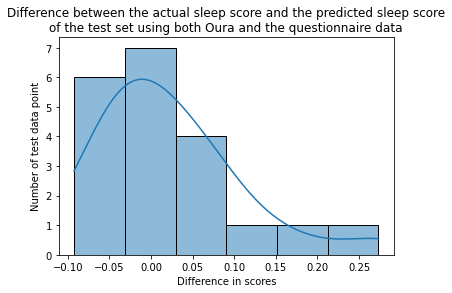

In [12]:
ax = sns.histplot(y_test-pred_test, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data point', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using both Oura and the questionnaire data')
plt.show()

## Apply LassoCV
### Using as independent variables all variables (Oura + questionnaire data)

In [13]:
lasso_cv = LassoCV(alphas=np.arange(0.01, 5, 0.01), cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)

print('Best alpha:', lasso_cv.alpha_)
pred_train, pred_test = compute_model(lasso_cv, X_train, y_train, X_test, y_test)

Best alpha: 0.01
R squared training set 0.999
R squared test set 0.996
MSE training set 0.001
MSE test set 0.002


In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=10))
sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=10))

In [15]:
sel_.get_support()

array([False,  True,  True,  True, False,  True, False, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False,  True,
        True,  True, False, False, False, False,  True,  True,  True,
        True,  True, False,  True,  True,  True, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False,  True, False, False,  True,  True, False, False,
       False, False, False, False,  True, False])

In [16]:
sel_.estimator_.coef_

array([ 0.00000000e+00, -5.68882874e-03, -4.07695148e-03,  3.50373332e-03,
       -0.00000000e+00, -7.12696770e-03, -0.00000000e+00, -0.00000000e+00,
       -4.58375688e-03, -1.21008903e-14,  6.29655168e-02,  2.95636183e-02,
        9.61271432e-02,  1.04713214e-01,  8.52790730e-02,  1.95779919e-01,
        3.76600858e-01,  1.82647325e-03,  2.92430944e-03, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        5.40612127e-03,  1.02165039e-01, -5.07842406e-03, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -3.41683763e-04,
        4.04669865e-03, -4.65849621e-03, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  8.18683096e-05, -1.15897161e-02,
       -2.03346897e-03, -2.24894405e-02,  5.47388616e-03,  0.00000000e+00,
       -9.74439208e-04, -4.66745937e-03, -9.76371317e-04, -0.00000000e+00,
        0.00000000e+00,  

In [17]:
print(sel_.get_feature_names_out())
print(len(sel_.get_feature_names_out()))

['x1' 'x2' 'x3' 'x5' 'x8' 'x10' 'x11' 'x12' 'x13' 'x14' 'x15' 'x16' 'x17'
 'x18' 'x28' 'x29' 'x30' 'x35' 'x36' 'x37' 'x42' 'x43' 'x44' 'x45' 'x46'
 'x48' 'x49' 'x50' 'x58' 'x59' 'x60' 'x65' 'x68' 'x69' 'x76']
35


In [18]:
selected_features = []
for i in range(len(sel_.get_support())):
    if sel_.get_support()[i] == True:
        selected_features.append(X_train.columns[i])

print('Number of selected features', len(selected_features))
selected_features

Number of selected features 35


['average_breath',
 'average_breath_variation',
 'average_heart_rate',
 'awake_time',
 'bedtime_start_delta',
 'contributors.deep_sleep',
 'contributors.efficiency',
 'contributors.latency',
 'contributors.rem_sleep',
 'contributors.restfulness',
 'contributors.timing',
 'contributors.total_sleep',
 'deep_sleep_duration',
 'efficiency',
 'readiness.contributors.previous_day_activity',
 'readiness.contributors.previous_night',
 'readiness.contributors.recovery_index',
 'readiness.temperature_trend_deviation',
 'rem_sleep_duration',
 'restless',
 'total_sleep_duration',
 'wake_ups',
 'prev_oura_score',
 'bed_time',
 'Comfort',
 'I walked a bit',
 'I went to the toilet',
 'Naturally',
 'prev_subjective_score',
 'Mentally active',
 'Physically active',
 'alcohol_time',
 'eat_bedtime',
 'intervention',
 'workout_intensity']

### Using as independent variables only the Oura data
#### Lasso

In [19]:
reg_oura, X_train_oura, X_test_oura, y_train_oura, y_test_oura = lasso_model(X_oura, y, random_state=995)

Number of coefficients 47
Non-zero coeffcients 21
Coefficients [-8.73878275e-04  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -7.08693999e-05  5.43631570e-05
  6.63363353e-18 -9.34308845e-05 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.66497756e-03  8.18365030e-03
  0.00000000e+00  1.00165702e-02  3.09793680e-05  0.00000000e+00
  0.00000000e+00  3.01096603e-04  1.14212899e-05  0.00000000e+00
 -2.36623177e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.37078810e-06  0.00000000e+00  1.62181473e-02 -1.27278953e-04
 -5.73463489e-04 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  3.25396808e-05 -0.00000000e+00 -0.00000000e+00
 -7.13923709e-05 -3.53185328e-06 -0.00000000e+00  1.07492075e-05
 -0.00000000e+00 -8.84035283e-04 -0.00000000e+00]


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e-01, tolerance: 3.820e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [20]:
pred_train, pred_test = compute_model(reg_oura, X_train_oura, y_train_oura, X_test_oura, y_test_oura)

R squared training set 0.993
R squared test set 0.942
MSE training set 0.004
MSE test set 0.049


## Applying the same model on the questionnaire data only

In [21]:
reg_quest, X_train_quest, X_test_quest, y_train_quest, y_test_quest = lasso_model(X_quest, y, random_state=995)

Number of coefficients 34
Non-zero coeffcients 9
Coefficients [-3.74646738e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.91832384e-01  2.98162620e-04 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.97572877e-02
 -1.01430656e-01 -4.28180564e-05 -0.00000000e+00  1.16778449e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.62180584e-04  1.32713321e-04]


/Users/user/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.084e-01, tolerance: 3.820e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [22]:
pred_train, pred_test = compute_model(reg_quest, X_train_quest, y_train_quest, X_test_quest, y_test_quest)

R squared training set 0.331
R squared test set 0.438
MSE training set 0.332
MSE test set 0.476
